<a href="https://colab.research.google.com/github/AsadiAhmad/Filtering-in-Frequency-Domain/blob/main/Code/Filtering_in_Frequency_Domain.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Step 1: Import Libraries

In [5]:
import cv2
import numpy as np
import math
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from itertools import chain

# Step 2: Download Images

In [6]:
!wget https://raw.githubusercontent.com/AsadiAhmad/Filtering-in-Frequency-Domain/main/Pictures/original_image.png -O original_image.png

--2025-05-10 17:17:30--  https://raw.githubusercontent.com/AsadiAhmad/Filtering-in-Frequency-Domain/main/Pictures/original_image.png
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10055 (9.8K) [image/png]
Saving to: ‘original_image.png’

original_image.png  100%[===================>]   9.82K  --.-KB/s    in 0s      

2025-05-10 17:17:30 (87.3 MB/s) - ‘original_image.png’ saved [10055/10055]



# Step 3: Load Image

In [7]:
original_image = cv2.imread("original_image.png", cv2.IMREAD_GRAYSCALE)

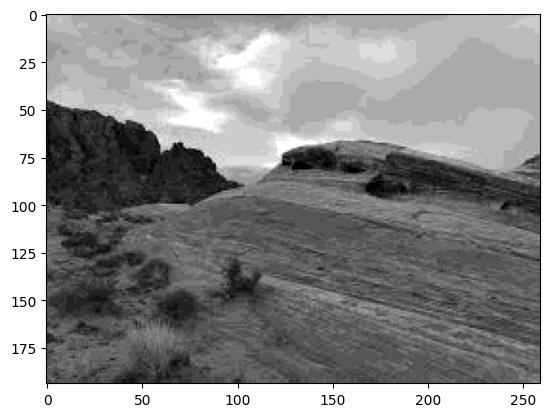

In [8]:
plt.imshow(original_image, cmap='gray')
plt.show()

# Step 4: Add Periodic Noise

In [9]:
def f(x,y):
  return np.sin((1/2)*np.pi*x)+np.cos((1/3)*np.pi*y)

In [10]:
X, Y = original_image.shape
noise = np.zeros((X, Y))
for i in range(X):
    for j in range(Y):
        noise[i,j] = f(i,j)*100

noisy_image = original_image + noise

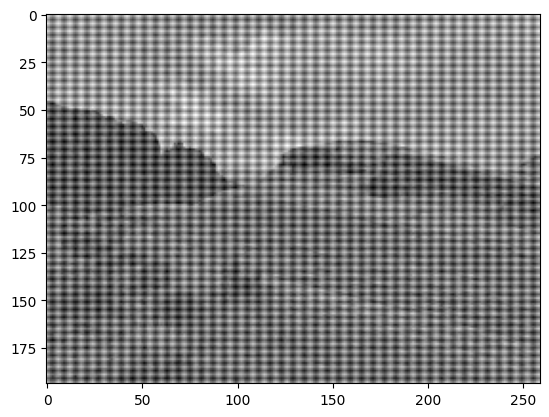

In [11]:
plt.imshow(noisy_image, cmap='gray')
plt.show()

# Step 5: Convert Image into the Frequency Domain

In [12]:
def convert_image_frequency(noisy_image):
    f_transform = np.fft.fft2(noisy_image)
    f_shifted = np.fft.fftshift(f_transform)
    return f_shifted

In [13]:
f_shifted = convert_image_frequency(noisy_image)

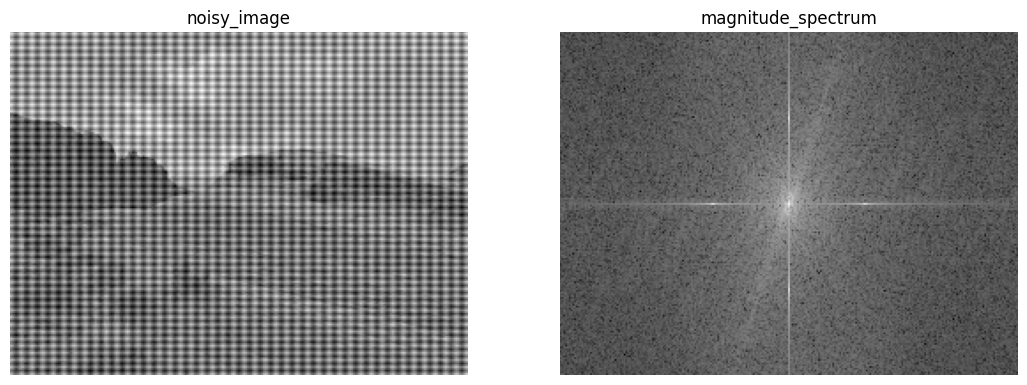

In [14]:
magnitude_spectrum = 20 * np.log(np.abs(f_shifted) + 1)
plt.figure(figsize=[13, 6])
plt.subplot(121),plt.imshow(noisy_image, cmap='gray'),plt.title('noisy_image'), plt.axis('off');
plt.subplot(122),plt.imshow(magnitude_spectrum, cmap='gray'),plt.title('magnitude_spectrum'), plt.axis('off');
plt.show()

# Step 6: Define a cross filter mask

In [15]:
def define_cross_filter_mask(shape, circle_reduce):
    height, width = shape
    filter_mask = np.ones((height, width), dtype=np.uint8)
    rectangle_width = (width // 2) - circle_reduce
    rectangle_height = (height // 2) - circle_reduce

    for i in chain(range(0, rectangle_height), range(height - rectangle_height, height)):
        for j in range(rectangle_width, width - rectangle_width):
            filter_mask[i, j] = 0

    for i in range(rectangle_height, height - rectangle_height):
        for j in chain(range(0, rectangle_width), range(width - rectangle_width, width)):
            filter_mask[i, j] = 0

    return filter_mask

In [16]:
mask = define_cross_filter_mask(f_shifted.shape, 2)
frequency_filtered = f_shifted * mask

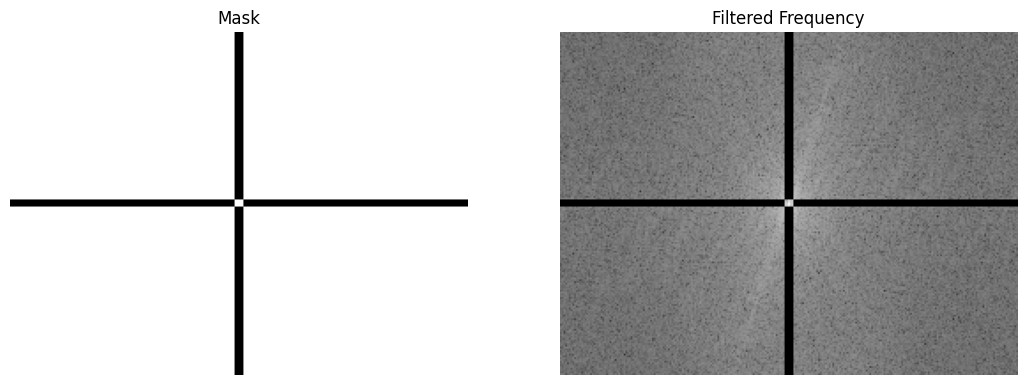

In [17]:
mask_visualization = mask * 255
magnitude_spectrum_filtered = magnitude_spectrum  * mask

plt.figure(figsize=[13, 6])
plt.subplot(121), plt.imshow(mask_visualization, cmap='gray'), plt.title('Mask'), plt.axis('off')
plt.subplot(122), plt.imshow(magnitude_spectrum_filtered, cmap='gray'), plt.title('Filtered Frequency'), plt.axis('off')
plt.show()

# Step 7: Inverse FFT

In [18]:
frequency_ishift = np.fft.ifftshift(frequency_filtered)
image_reconstructed = np.fft.ifft2(frequency_ishift)
image_reconstructed = np.abs(image_reconstructed)

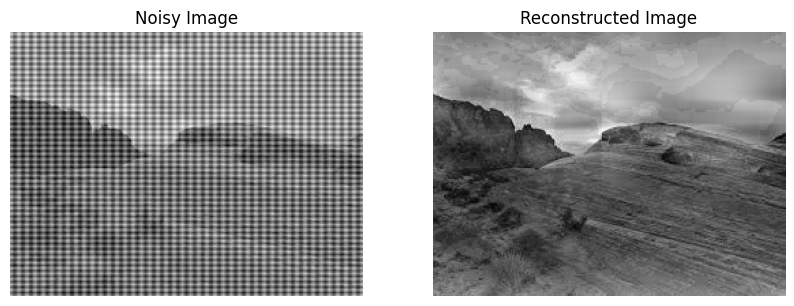

In [19]:
plt.figure(figsize=(10, 4))
plt.subplot(121), plt.imshow(noisy_image, cmap="gray"), plt.title("Noisy Image"), plt.axis('off')
plt.subplot(122), plt.imshow(image_reconstructed, cmap="gray"), plt.title("Reconstructed Image"), plt.axis('off')
plt.show()

# Step 8: Compare Original Image with Reconstructed Image

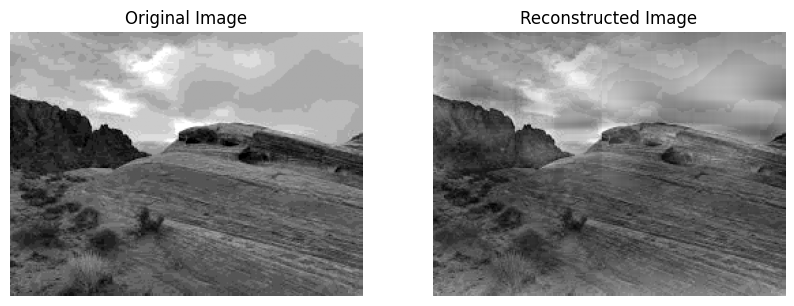

In [25]:
plt.figure(figsize=(10, 4))
plt.subplot(121), plt.imshow(original_image, cmap="gray"), plt.title("Original Image"), plt.axis('off')
plt.subplot(122), plt.imshow(image_reconstructed, cmap="gray"), plt.title("Reconstructed Image"), plt.axis('off')
plt.show()

# Step 9: Quality Assurance with PSNR

In [21]:
def psnr(original, noisy):
    mse = np.mean((original - noisy) ** 2)
    if mse == 0:
        return 100
    PIXEL_MAX = 255.0
    psnr_value = 20 * math.log10(PIXEL_MAX / math.sqrt(mse))
    return psnr_value

In [22]:
original_float = original_image.astype(np.float32)
noisy_float = noisy_image.astype(np.float32)
reconstructed_float = image_reconstructed.astype(np.float32)

In [23]:
psnr_noisy = psnr(original_float, noisy_float)
psnr_reconstructed = psnr(original_float, reconstructed_float)

print(f"PSNR (Original vs Noisy): {psnr_noisy:.2f} dB")
print(f"PSNR (Original vs Reconstructed): {psnr_reconstructed:.2f} dB")

PSNR (Original vs Noisy): 8.12 dB
PSNR (Original vs Reconstructed): 19.47 dB
